In [1558]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import string
from tqdm import tqdm
import os
import numpy as np
import cv2
from ultralytics import YOLO
import pillow_heif

# Faster RCNN

In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [ ]:
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="./renamed_data/train",
    ann_file="./renamed_data/train/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="./renamed_data/valid",
    ann_file="./renamed_data/valid/_annotations.coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
def get_model(num_classes, path = None):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if path:
        state_dict = torch.load(path, map_location='cpu')
        model.load_state_dict(state_dict)
    return model

In [ ]:
# Initialize the model
num_classes = 7 # Background + chair, human, table
model = get_model(num_classes, './dice_face_detector_1.pth')

In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")

In [ ]:
def validation_loss(model, val_loader, device):
    losses = []
    with torch.no_grad():
        for images, targets in val_loader:
            # Move images to the device
            images = [img.to(device) for img in images]
    
            # Validate and process targets
            processed_targets = []
            valid_images = []
            for i, target in enumerate(targets):
                boxes = []
                labels = []
                for obj in target:
                    # Extract bbox
                    bbox = obj["bbox"]  # Format: [x, y, width, height]
                    x, y, w, h = bbox
    
                    # Ensure the width and height are positive
                    if w > 0 and h > 0:
                        boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                        labels.append(obj["category_id"])
    
                # Only process if there are valid boxes
                if boxes:
                    processed_target = {
                        "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                        "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                    }
                    processed_targets.append(processed_target)
                    valid_images.append(images[i])  # Add only valid images
    
            # Ensure images and targets are aligned
            images = valid_images
    
            # Forward pass
            loss_dict = model(images, processed_targets)
            losses.append(sum(loss for loss in loss_dict.values()))
    avg_loss = sum(losses)/len(losses)
    print(f"Average Loss over batches {avg_loss}")
    return avg_loss

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    step = 0
    for images, targets in tqdm(data_loader):
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        step += 1
        if step % 200 == 0:
            lr_scheduler.step(validation_loss(model, val_loader, device))
        elif step % 100 == 0:
            print(f"Train Loss {losses.item()}")

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [ ]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


def validate_performance(model, val_loader, device):
    model.eval()
    coco_dt = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating"):
            images = [img.to(device) for img in images]
            predictions = model(images)

            for target, prediction in zip(targets, predictions):
                image_id = target[0]['image_id']  # ensure int
                for i in range(len(prediction['boxes'])):
                    x1, y1, x2, y2 = prediction['boxes'][i].tolist()
                    w, h = x2 - x1, y2 - y1

                    coco_dt.append({
                        "image_id": image_id,
                        "category_id": prediction['labels'][i].item(),
                        "bbox": [x1, y1, w, h],
                        "score": prediction['scores'][i].item()
                    })
                    
    # Load ground truth and detections
    anno_path = '/kaggle/input/dace-face/renamed_data/valid/_annotations.coco.json'
    coco_gt = COCO(anno_path)
    coco_dt = coco_gt.loadRes(coco_dt)

    # Run COCO evaluation
    cocoEval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    validate_performance(model, val_loader,device)
    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

# Visualize

In [ ]:

model.to(device)
model.eval()  # Set the model to evaluation mode

COCO_CLASSES = {0: "0", 1: "1", 2: "2", 3: "3", 4:"4", 5:"5", 6:"6"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

In [ ]:
images , targets = next(iter(val_loader))

images = [img.to(device) for img in images]

predictions = model(images)

for i, target in enumerate(targets):
    boxes = predictions[i]['boxes'].cpu().detach().numpy()  # Get predicted bounding boxes
    labels = predictions[i]['labels'].cpu().detach().numpy()  # Get predicted labels
    scores = predictions[i]['scores'].cpu().detach().numpy()  # Get predicted scores
    
    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.4

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(images[i].cpu().detach().permute(1,2,0))  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')
    
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
image , targets = next(iter(val_loader))

prediction = model(image)

for i, target in enumerate(targets):
        print(target)
        boxes = []
        labels = []
        for obj in target:
            # Extract bbox
            bbox = obj["bbox"]  # Format: [x, y, width, height]
            x, y, w, h = bbox

            # Ensure the width and height are positive
            if w > 0 and h > 0:
                boxes.append([x, y, w, h])  # Convert to [x_min, y_min, x_max, y_max]
                labels.append(obj["category_id"])
        if boxes:
            # processed_target = {
            #     "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
            #     "labels": torch.tensor(labels, dtype=torch.int64).to(device),
            # }
            for box, label in zip(boxes, labels):
                x_min, y_min, w, h = box
                class_name = get_class_name(label)  # Get the class name
                plt.imshow(image[i].permute(1,2,0))  # Display the image
                plt.gca().add_patch(plt.Rectangle((x_min, y_min), w, h, 
                                                  linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x_min, y_min, f"{class_name} ({1})", color='r')
            plt.axis('off')  # Turn off axis
            plt.show()
            

# Test on Real Images

In [ ]:
from PIL import Image
import numpy as np

# Enable HEIC reading via Pillow
from pillow_heif import register_heif_opener
register_heif_opener()
# dataset_dir = './datasets/combined_data/'

In [ ]:
img = Image.open(f'./datasets/real_data/IMG_3874.HEIC')
arr = np.array(img)

# Helper Functions

## Relable Images

In [ ]:
def relabel_images(dataset_dir, set):
    for file in os.listdir(f'{dataset_dir}{set}/labels'):
        new_label = ""
        with open(f'{dataset_dir}{set}/labels/{file}', 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.split() 
                line[0] = '0'
                line = " ".join(line)
                new_label += line + "\n"
            new_label = new_label[:-1]
        f.close()
        # save the new label as the same file
        with open(f'{dataset_dir}{set}/labels/{file}', 'w') as f:
            f.write(new_label)
        f.close()

dataset_dir = './datasets/obj_det/'
relabel_images(dataset_dir, 'train')
relabel_images(dataset_dir, 'valid')

In [ ]:
def relabel_images(dataset_dir, split):
    labels_path = os.path.join(dataset_dir, split, "labels")
    for file in os.listdir(labels_path):
        if file.startswith("2020"):
            new_lines = []
            with open(os.path.join(labels_path, file), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"⚠️ Skipping malformed line in {file}: {line}")
                        continue
                    cls = str(int(parts[0]) + 1)
                    coords = " ".join(parts[1:])
                    new_lines.append(f"{cls} {coords}")

            with open(os.path.join(labels_path, file), "w") as f:
                f.write("\n".join(new_lines))

dataset_dir = "./datasets/new_data"
relabel_images(dataset_dir, "train")
relabel_images(dataset_dir, "valid")

## Raname Images

In [ ]:
def generate_alphanumeric(length=8):
    chars = string.ascii_letters + string.digits  # A-Z, a-z, 0-9
    return ''.join(random.choice(chars) for _ in range(length))

data_set = 'valid'
dir = f'./renamed_data/{data_set}'
annotation_file = os.path.join(dir, "_annotations.coco.json")

# Load annotations.json
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Build a mapping of old -> new filenames
rename_map = {}

for file in tqdm(os.listdir(dir)):
    if file.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
        new_name = generate_alphanumeric() + os.path.splitext(file)[1]  # Preserve extension
        old_path = os.path.join(dir, file)
        new_path = os.path.join(dir, new_name)

        os.rename(old_path, new_path)
        rename_map[file] = new_name

# Update JSON file names
for img in annotations.get("images", []):
    if img["file_name"] in rename_map:
        img["file_name"] = rename_map[img["file_name"]]

# Save updated JSON
with open(annotation_file, "w") as f:
    json.dump(annotations, f, indent=4)

print("Renaming completed and annotations.json updated.")


## Read HEIC Images

In [ ]:
def read_image(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in {".heic", ".heif"}:
        heif_file = pillow_heif.read_heif(path)
        image = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    else:
        return cv2.imread(path)

## Generate Yolo Labels

In [1557]:
def predict_yolo_labels(model, image_folder, labels_folder):
    for img in tqdm(os.listdir(image_folder)):
        image_path = os.path.join(image_folder, img)
        image = read_image(image_path)

        
        results = model(image)
        for r in results:
            # Get image shape
            h, w = r.orig_shape

            # Get filename without extension
            img_name = os.path.splitext(os.path.basename(image_path))[0]
            label_path = os.path.join(labels_folder, f"{img_name}.txt")

            with open(label_path, "w") as f:
                for box, cls in zip(r.boxes.xyxy, r.boxes.cls):
                    x1, y1, x2, y2 = box.tolist()

                    # Convert to YOLO format (relative coords)
                    x_center = (x1 + x2) / 2 / w
                    y_center = (y1 + y2) / 2 / h
                    bw = (x2 - x1) / w
                    bh = (y2 - y1) / h

                    f.write(f"{int(cls.item()) + 1} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}\n")

        # print(f"Saved labels → {label_path}")


# Training Yolo

In [ ]:

dataset_dir = f'./datasets/obj_det/'
model = YOLO('yolo12m.pt')

In [ ]:
# results = model.train(
#   data=f'{dataset_dir}/data.yaml',
#   epochs=20,
#   device="mps" if torch.backends.mps.is_available() else "cpu",
#   single_cls=True
# )
# from pathlib import Path

# dataset = [Path(p) for p in Path(f"{dataset_dir}/train/images").glob("*.jpg")]

# model.train(data=f'{dataset_dir}/data.yaml', epochs=10, device="mps", batch=8)

In [1551]:

from ultralytics import YOLO


img = Image.open(f'./datasets/real_data/IMG_3855.HEIC')
arr = np.array(img)
# model.export(format="onnx", overrides={"imgsz": 640})
# model.save("dice_face_detector_1.pt")

# model_name = "dice_face_detector_1.pt"
model_name = "cls.pt"

model2 = YOLO(model_name)

In [1552]:
# Perform object detection
results = model2(arr, conf=0.5)


0: 640x480 2 1s, 1 2, 1 3, 1 5, 1 6, 168.2ms
Speed: 2.2ms preprocess, 168.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


In [1553]:
import numpy as np

def filter_max_area_boxes(result, iou_threshold=0.5):
    boxes = result.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # Sort indices by area descending
    idxs = np.argsort(-areas)

    keep = []
    while len(idxs) > 0:
        current = idxs[0]
        keep.append(current)

        rest = idxs[1:]
        if len(rest) == 0:
            break

        # Compute IoU with rest
        xx1 = np.maximum(boxes[current, 0], boxes[rest, 0])
        yy1 = np.maximum(boxes[current, 1], boxes[rest, 1])
        xx2 = np.minimum(boxes[current, 2], boxes[rest, 2])
        yy2 = np.minimum(boxes[current, 3], boxes[rest, 3])

        inter_w = np.maximum(0, xx2 - xx1)
        inter_h = np.maximum(0, yy2 - yy1)
        inter_area = inter_w * inter_h

        union_area = areas[current] + areas[rest] - inter_area
        iou = inter_area / (union_area + 1e-6)

        # keep only boxes with IoU less than threshold
        idxs = rest[iou < iou_threshold]

    # Keep filtered boxes
    result.boxes = result.boxes
    return result


# Example usage
for r in results:
    filtered = filter_max_area_boxes(r, iou_threshold=0.2)
    filtered.show()


# Training CNN

In [ ]:
from collections import defaultdict
import pandas as pd


def crop_faces(dataset_dir, split):
    class_count = defaultdict(int)

    images = os.listdir(f'{dataset_dir}/{split}/images')
    for image_id, file in  enumerate(tqdm(images)):
        filename = ".".join(file.split('.')[:-1])
        img = cv2.imread(f'{dataset_dir}/{split}/images/{file}')
        if os.path.exists(f'{dataset_dir}/{split}/labels/{filename}.txt'):
            h, w = img.shape[:2]
            with open(f'{dataset_dir}/{split}/labels/{filename}.txt', "r") as f:
                for box_id, line in enumerate(f.readlines()):
                    if len(line.strip().split()) > 5:
                        print(filename, "\n", line)
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls) + 1
                    class_count[cls] += 1

                    # Convert normalized xywh → absolute xyxy
                    # convert normalized → absolute
                    x_center = x * w       
                    y_center = y * h       
                    box_w    = bw * w      
                    box_h    = bh * h      

                    x1 = int(x_center - box_w / 2)
                    y1 = int(y_center - box_h / 2)
                    x2 = int(x_center + box_w / 2)
                    y2 = int(y_center + box_h / 2)

                    crop = img[y1:y2, x1:x2]
                    if crop.size == 0:
                        continue
                    # Folder per class
                    cv2.imwrite(f'./datasets/dice_face_cropped/{split}/{cls}/{image_id}_{box_id}_{cls}.jpg', crop)
    print(class_count)

crop_faces('./datasets/premium_labeled', 'valid')

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


dataset_dir = './datasets/dice_face_crp'


for split in ['train', 'valid']:
    annotation_file = {
        "images": [],
        "labels": [],
    }
    for cls in range(1,7):
        for image in os.listdir(f'{dataset_dir}/{split}/{cls}'):
            annotation_file['images'].append(f'{image}')
            annotation_file['labels'].append(cls)

    annotation_file = pd.DataFrame(annotation_file)
    annotation_file.to_csv(f'{dataset_dir}/{split}_annotations.csv', index=False)


In [ ]:
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir,str(self.img_labels.iloc[idx, 1]),self.img_labels.iloc[idx, 0])
        # print(img_path)
        image = decode_image(img_path).to(torch.float32) / 255.0
        label = self.img_labels.iloc[idx, 1] - 1
        return image, label

In [ ]:
train_dataset = CustomImageDataset(
    annotations_file=f'{dataset_dir}/train_annotations.csv',
    img_dir=f'{dataset_dir}/train',
    transform=ToTensor()
)
valid_dataset = CustomImageDataset(
    annotations_file=f'{dataset_dir}/valid_annotations.csv',
    img_dir=f'{dataset_dir}/valid',
    transform=ToTensor()
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.model = nn.Sequential(
            # Input: (3, 128, 128)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),   # -> (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),  # -> (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),  # -> (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # -> (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),  # -> (128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# -> (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),  # -> (256, 8, 8)

            nn.AdaptiveAvgPool2d((2, 2)),  # -> (256, 1, 1)
            nn.Flatten(),                  # -> (256,)
            nn.Linear(1024, 256),    # final classifier
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)    # final classifier
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch.optim as optim

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
cls_model = SimpleCNN().to(device)

num_epochs = 50
learning_rate = 0.00005
weight_decay = 0.001 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    cls_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1
)

In [ ]:
from sklearn.metrics import confusion_matrix

def validation_metrics(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    full_labels = []
    full_predicted = []
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            full_labels.extend(labels.cpu().numpy())
            _, predicted = torch.max(outputs.data, 1)
            full_predicted.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # compute mean loss and accuracy
    val_loss = running_loss / total
    accuracy = 100 * correct / total
    report = confusion_matrix(full_labels, full_predicted)

    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy, report

In [ ]:
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
    train_loss = 0
    cls_model.train()
    steps = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = cls_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        steps += 1
        if steps % 50 == 0:
            print(f"Train Loss {loss.item()}")
    train_loss_list.append(train_loss / len(train_loader))
    val_loss, acc, cm =validation_metrics(cls_model, valid_loader, device)
    # step with validation metric
    scheduler.step(val_loss)
    print(f"Training loss = {train_loss_list[-1]}")

In [ ]:
acc, report = validation_metrics(cls_model, valid_loader, device)

In [ ]:
report

In [ ]:
features, labels = next(iter(valid_loader))
prediction = cls_model(features.to(device))

print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}, Predicted: {torch.argmax(prediction[0])}")

---------------------------------------------------

# YOLO Infrence

In [1559]:


def filter_and_crop_objects(result, image, iou_threshold=0.5):
    boxes = result.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    idxs = np.argsort(-areas)  # Descending by area
    keep = []

    while len(idxs) > 0:
        current = idxs[0]
        keep.append(current)

        rest = idxs[1:]
        if len(rest) == 0:
            break

        xx1 = np.maximum(boxes[current, 0], boxes[rest, 0])
        yy1 = np.maximum(boxes[current, 1], boxes[rest, 1])
        xx2 = np.minimum(boxes[current, 2], boxes[rest, 2])
        yy2 = np.minimum(boxes[current, 3], boxes[rest, 3])

        inter_w = np.maximum(0, xx2 - xx1)
        inter_h = np.maximum(0, yy2 - yy1)
        inter_area = inter_w * inter_h

        union_area = areas[current] + areas[rest] - inter_area
        iou = inter_area / (union_area + 1e-6)

        idxs = rest[iou < iou_threshold]

    # Crop boxes from image
    cropped_images = []
    for idx in keep:
        x1, y1, x2, y2 = boxes[idx].astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)
        cropped = image[y1:y2, x1:x2]
        cropped_images.append(cropped)

    return cropped_images


In [1560]:
import torch
import cv2
import matplotlib.pyplot as plt

def run_inference_and_show(crops, model, device, classes=None, rows=2, cols=5, size=(128,128)):
    # Preprocess crops → tensor batch
    tensors = []
    for crop in crops:
        resized = cv2.resize(crop, size)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        # Random horizontal flip
        rgb = cv2.flip(rgb, 1)  # 1 = horizontal

        rgb = cv2.flip(rgb, 0) 
        tensor = torch.tensor(rgb).permute(2,0,1).float() / 255.0  # [C,H,W], normalize 0-1
        tensors.append(tensor)

    batch = torch.stack(tensors).to(device)

    # Run inference
    with torch.no_grad():
        preds = model(batch)
        pred_ids = torch.argmax(preds, dim=1).cpu().tolist()

    # Plot
    plt.figure(figsize=(cols*2, rows*2))
    for i, (img, pred) in enumerate(zip(crops, pred_ids)):
        if i >= rows*cols:
            break
        resized = cv2.resize(img, size)
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i+1)
        plt.imshow(rgb)
        plt.axis("off")
        pred_text = classes[pred] if classes else str(pred)
        plt.title(f"Pred: {pred_text}", fontsize=10)

    plt.tight_layout()
    plt.show()



0: 640x480 1 3, 2 4s, 161.9ms
Speed: 1.8ms preprocess, 161.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


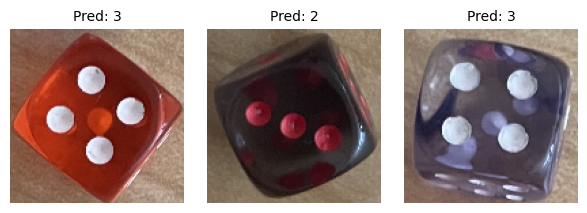

In [1561]:
# for single image

# Get first result (YOLO returns a list)
testing_dir = "./datasets/real_data/"
image_file = random.choice(os.listdir(testing_dir))
arr = read_image(testing_dir + image_file)


results = model2(arr, conf=0.4)

result = filter_max_area_boxes(results[0], iou_threshold=0.6)

# Filter and crop detected objects
cropped_objects = filter_and_crop_objects(result, arr, iou_threshold=0.5)
run_inference_and_show(cropped_objects, cls_model, device, classes=None, rows=3, cols=5, size=(128,128))
result.show()


--------------------------

In [ ]:
# HEIC images

image_folder = "datasets/testing/6"
output_folder = image_folder
os.makedirs(output_folder, exist_ok=True)

model = YOLO("best.pt")

# Add .heic and .heif extensions
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".heic", ".heif"}


for filename in os.listdir(image_folder):
    if not any(filename.lower().endswith(ext) for ext in valid_exts):
        continue  

    image_path = os.path.join(image_folder, filename)
    image = read_image(image_path)
    if image is None:
        print(f"⚠️ Skipping unreadable image: {filename}")
        continue

    results = model(image)
    result = results[0]

    cropped_objects = filter_and_crop_objects(result, image, iou_threshold=0.3)

    base_name = os.path.splitext(filename)[0]
    for i, crop in enumerate(cropped_objects):
        out_path = os.path.join(output_folder, f"{base_name}_crop_{i}.png")
        cv2.imwrite(out_path, crop)
        print(f"✅ Saved: {out_path}")



0: 640x608 2 items, 173.7ms
Speed: 1.7ms preprocess, 173.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)
✅ Saved: datasets/testing/6/IMG_4605_crop_1_crop_0.png
✅ Saved: datasets/testing/6/IMG_4605_crop_1_crop_1.png

0: 640x640 3 items, 175.3ms
Speed: 1.0ms preprocess, 175.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
✅ Saved: datasets/testing/6/IMG_4605_crop_11_crop_0.png
✅ Saved: datasets/testing/6/IMG_4605_crop_11_crop_1.png
✅ Saved: datasets/testing/6/IMG_4605_crop_11_crop_2.png

0: 608x640 6 items, 162.9ms
Speed: 0.9ms preprocess, 162.9ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)
✅ Saved: datasets/testing/6/IMG_4605_crop_10_crop_0.png
✅ Saved: datasets/testing/6/IMG_4605_crop_10_crop_1.png
✅ Saved: datasets/testing/6/IMG_4605_crop_10_crop_2.png
✅ Saved: datasets/testing/6/IMG_4605_crop_10_crop_3.png
✅ Saved: datasets/testing/6/IMG_4605_crop_10_crop_4.png
✅ Saved: datasets/testing/6/IMG_4605_crop_10_crop_5.png

0: 6

KeyboardInterrupt: 

defaultdict(<class 'int'>, {'3': 4948, '0': 4604, '5': 4920, '4': 4986, '2': 5331, '1': 5225})
defaultdict(<class 'int'>, {'0': 257, '2': 196, '4': 238, '5': 241, '1': 205, '3': 222})

In [1505]:
img_list = [
'IMG_4593_',
'IMG_4602_',
'IMG_4585_',
'IMG_4634_',
'IMG_4622_',
'IMG_4570_',
'IMG_4618_',
'IMG_4589_',
'IMG_4588_',
'IMG_4619_',
'IMG_4571_',
'IMG_4623_',
'IMG_4584_',
'IMG_4615_',
'IMG_4603_',
'IMG_4592_',
'IMG_4506_',
'IMG_4632_',
'IMG_4624_',
'IMG_4599_',
'IMG_4608_',
'IMG_4628_',
'IMG_4595_',
'IMG_4604_',
'IMG_4583_',
'IMG_4582_',
'IMG_4605_',
'IMG_4594_',
'IMG_4629_',
'IMG_4557_',
'IMG_4598_',
'IMG_4625_',
'IMG_4222_',
'IMG_4633_',
'IMG_4466_',
'IMG_4574_',
'IMG_4626_',
'IMG_4630_',
'IMG_4581_',
'IMG_4610_',
'IMG_4606_',
'IMG_4554_',
'IMG_4555_',
'IMG_4579_',
'IMG_4596_',
'IMG_4580_',
'IMG_4631_',
'IMG_4627_',
'IMG_4575_',
'IMG_4568_',
'IMG_4616_',
'IMG_4600_',
'IMG_4591_',
'IMG_4552_',
'IMG_4620_',
'IMG_4621_',
'IMG_4573_',
'IMG_4590_',
'IMG_4601_',
'IMG_4617_',
'IMG_4569_',
'IMG_4586_'
]
len(img_list)

62